In [86]:
import pandas as pd
import numpy as np
import pickle
import shap

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import mean_squared_error

pd.set_option("display.max_columns", 0)

In [87]:
def get_best_parameters(X_train, y_train, max_evals=230):                                                                                                   

    kf = KFold(n_splits=5, shuffle=True, random_state=17)
    
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 300, 5),
        'max_depth': hp.quniform('max_depth', 1, 20, 1),
        'learning_rate': hp.uniform('learning_rate', 0, 1),
        'booster': hp.choice('booster', ['gbtree']),
        'gamma': hp.uniform('gamma', 0, 0.50),
        'min_child_weight': hp.uniform('min_child_weight', 0, 10),
        'subsample': hp.uniform('subsample', 0, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
        'reg_alpha': hp.uniform('reg_alpha', 0, 5),
        'reg_lambda': hp.uniform('reg_lambda', 0, 5),
    }

    def train_XGBoost(space):
    
        model = XGBRegressor(
            n_estimators      = int(space['n_estimators']),
            max_depth         = int(space['max_depth']),
            learning_rate     = space['learning_rate'],
            booster           = space['booster'],
            gamma             = space['gamma'],
            min_child_weight  = space['min_child_weight'],
            subsample         = space['subsample'],
            colsample_bytree  = space['colsample_bytree'],
            reg_alpha         = space['reg_alpha'],
            reg_lambda        = space['reg_lambda'],
            eval_metric       = 'rmse',
            random_state      = 17)

        scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')

        return{
            'loss': -np.mean(scores), 
            'loss_variance': np.var(scores, ddof=1),
            'status': STATUS_OK}

    best_hyperparameters = fmin(
        fn=train_XGBoost,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        early_stop_fn=no_progress_loss(20)
        )

    return space_eval(space, best_hyperparameters)

In [88]:
df = pd.read_csv('resources/dataset.csv', index_col=0)
df.head()

,season,matchId,team,homeTeam,awayTeam,goalsScored,goalsConceded,xGScored,xGConceded,time,date,teamOpponent,goalsScoredOpponent,goalsConcededOpponent,xGScoredOpponent,xGConcededOpponent,timeOpponent,playerId,player,homeOrAway,position,timePlayer,goals,assists,shots,yellowCard,redCard,xG,xA,bonus,xB,lastBonus,target,homeWinOdds,drawOdds,awayWinOdds,>2.5Odds,<2.5Odds
0,2014,5149,Chievo,Chievo,Juventus,0,0,0.0,0.0,0,2014-08-30 17:00:00,Juventus,0,0,0.0,0.0,0,1989,Francesco Bardi,h,GK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.01,3.9,1.53,1.98,1.8
1,2014,5149,Chievo,Chievo,Juventus,0,0,0.0,0.0,0,2014-08-30 17:00:00,Juventus,0,0,0.0,0.0,0,1344,Nicolas Frey,h,DR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.01,3.9,1.53,1.98,1.8
2,2014,5149,Chievo,Chievo,Juventus,0,0,0.0,0.0,0,2014-08-30 17:00:00,Juventus,0,0,0.0,0.0,0,1331,Dario Dainelli,h,DC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.5,7.01,3.9,1.53,1.98,1.8
3,2014,5149,Chievo,Chievo,Juventus,0,0,0.0,0.0,0,2014-08-30 17:00:00,Juventus,0,0,0.0,0.0,0,1572,Bostjan Cesar,h,DC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.01,3.9,1.53,1.98,1.8
4,2014,5149,Chievo,Chievo,Juventus,0,0,0.0,0.0,0,2014-08-30 17:00:00,Juventus,0,0,0.0,0.0,0,1164,Cristiano Biraghi,h,DL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.01,3.9,1.53,1.98,1.8


In [89]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekDay'] = df['date'].dt.weekday

In [90]:
df['G90P'] = df['goals'] / df['timePlayer'] * 90
df['A90P'] =  df['assists'] / df['timePlayer'] * 90
df['s90P'] =  df['shots'] / df['timePlayer'] * 90
df['yC90P'] = df['yellowCard'] / df['timePlayer'] * 90
df['rC90P'] = df['redCard'] / df['timePlayer'] * 90
df['B90P'] = df['bonus'] / df['timePlayer'] * 90
df['xG90P'] = df['xG'] / df['timePlayer'] * 90
df['xA90P'] = df['xA'] / df['timePlayer'] * 90
df['xB90P'] = df['xB'] / df['timePlayer'] * 90

In [91]:
df['G90T'] = df['goalsScored'] / df['time'] * 90
df['GC90T'] = df['goalsConceded'] / df['time'] * 90
df['xG90T'] = df['xGScored'] / df['time'] * 90
df['xGC90T'] = df['xGConceded'] / df['time'] * 90

In [92]:
df['G90OT'] = df['goalsScoredOpponent'] / df['timeOpponent'] * 90
df['GC90OT'] = df['goalsConcededOpponent'] / df['timeOpponent'] * 90
df['xG90OT'] = df['xGScoredOpponent'] / df['timeOpponent'] * 90
df['xGC90OT'] = df['xGConcededOpponent'] / df['timeOpponent'] * 90

In [93]:
df['homeWinOdds'] = 1/df['homeWinOdds']
df['drawOdds'] = 1/df['drawOdds']
df['awayWinOdds'] = 1/df['awayWinOdds']
df['>2.5Odds'] = 1/df['>2.5Odds']
df['<2.5Odds'] = 1/df['<2.5Odds']

df['homeWinOdds'] = df['homeWinOdds']/(df['homeWinOdds'] + df['drawOdds'] + df['awayWinOdds'])
df['drawOdds'] = df['drawOdds']/(df['homeWinOdds'] + df['drawOdds'] + df['awayWinOdds'])
df['awayWinOdds'] = df['awayWinOdds']/(df['homeWinOdds'] + df['drawOdds'] + df['awayWinOdds'])
df['+2.5Odds'] = df['>2.5Odds']/(df['>2.5Odds'] + df['<2.5Odds'])
df['-2.5Odds'] = df['<2.5Odds']/(df['>2.5Odds'] + df['<2.5Odds'])

In [94]:
df = df[[
    'matchId',
    'player',
    'team',
    
    'homeTeam',
    'awayTeam',
    'homeOrAway',
    
    'season',
    'month',
    'day',
    'weekDay',
    
    'position',
    'G90P',
    'A90P',
    's90P',
    'yC90P',
    'rC90P',
    'B90P',
    'xG90P',
    'xA90P',
    'xB90P',
    'timePlayer',
    'lastBonus',
    
    'G90T',
    'GC90T',
    'xG90T',
    'xGC90T',
    
    'G90OT',
    'GC90OT',
    'xG90OT',
    'xGC90OT',
    
    'homeWinOdds',
    'drawOdds',
    'awayWinOdds',
    '+2.5Odds',
    '-2.5Odds',
    
    'target'
]]

In [95]:
df = df[df.position != 'GK']
df = df.fillna(0)
df.head()

,matchId,player,team,homeTeam,awayTeam,homeOrAway,season,month,day,weekDay,position,G90P,A90P,s90P,yC90P,rC90P,B90P,xG90P,xA90P,xB90P,timePlayer,lastBonus,G90T,GC90T,xG90T,xGC90T,G90OT,GC90OT,xG90OT,xGC90OT,homeWinOdds,drawOdds,awayWinOdds,+2.5Odds,-2.5Odds,target
1,5149,Nicolas Frey,Chievo,Chievo,Juventus,h,2014,8,30,5,DR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.135517,0.245246,0.631884,0.47619,0.52381,0.0
2,5149,Dario Dainelli,Chievo,Chievo,Juventus,h,2014,8,30,5,DC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.135517,0.245246,0.631884,0.47619,0.52381,-0.5
3,5149,Bostjan Cesar,Chievo,Chievo,Juventus,h,2014,8,30,5,DC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.135517,0.245246,0.631884,0.47619,0.52381,0.0
4,5149,Cristiano Biraghi,Chievo,Chievo,Juventus,h,2014,8,30,5,DL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.135517,0.245246,0.631884,0.47619,0.52381,0.0
5,5149,Thomas Mangani,Chievo,Chievo,Juventus,h,2014,8,30,5,MC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.135517,0.245246,0.631884,0.47619,0.52381,-0.5


In [96]:
metadata = df[['matchId', 'player', 'team']]
X = df.drop(columns=['matchId', 'player', 'team', 'target'])
y = df.target

X_train_raw, X_test_raw, y_train, y_test, metadata_train, metadata_test = train_test_split(X, y, metadata, test_size=0.33, random_state=17)

In [97]:
categorical_columns = ['homeTeam', 'awayTeam', 'homeOrAway', 'position']
numerical_columns = [column for column in list(X.columns) if column not in categorical_columns]

In [98]:
ct = ColumnTransformer([
    ("scaler", StandardScaler(), numerical_columns),
    ("encoder", OneHotEncoder(drop='if_binary', sparse=False), categorical_columns)    
])

In [99]:
X_train_values = ct.fit_transform(X_train_raw)
X_test_values = ct.transform(X_test_raw)

In [100]:
feature_names = ct.transformers_[0][2]
encoded_features = ct.transformers_[1][1].get_feature_names()

temp = []
for index, feature in enumerate(ct.transformers_[1][2]):
    for column in encoded_features:
        if 'x'+str(index)+'_' in column:
            temp.append(column.replace('x'+str(index)+'_', feature+'_'))
            
feature_names.extend(temp)

In [101]:
X_train = pd.DataFrame(data=X_train_values, columns=feature_names)
X_test = pd.DataFrame(data=X_test_values, columns=feature_names)

X_train.head()

,season,month,day,weekDay,G90P,A90P,s90P,yC90P,rC90P,B90P,xG90P,xA90P,xB90P,timePlayer,lastBonus,G90T,GC90T,xG90T,xGC90T,G90OT,GC90OT,xG90OT,xGC90OT,homeWinOdds,drawOdds,awayWinOdds,+2.5Odds,-2.5Odds,homeTeam_Atalanta,homeTeam_Benevento,homeTeam_Bologna,homeTeam_Brescia,homeTeam_Cagliari,homeTeam_Carpi,homeTeam_Cesena,homeTeam_Chievo,homeTeam_Crotone,homeTeam_Empoli,homeTeam_Fiorentina,homeTeam_Frosinone,homeTeam_Genoa,homeTeam_Inter,homeTeam_Juventus,homeTeam_Lazio,homeTeam_Lecce,homeTeam_Napoli,homeTeam_Palermo,homeTeam_Parma,homeTeam_Pescara,homeTeam_Roma,homeTeam_Salernitana,homeTeam_Sampdoria,homeTeam_Sassuolo,homeTeam_Spezia,homeTeam_Torino,homeTeam_Udinese,homeTeam_Venezia,homeTeam_Verona,awayTeam_Atalanta,awayTeam_Benevento,awayTeam_Bologna,awayTeam_Brescia,awayTeam_Cagliari,awayTeam_Carpi,awayTeam_Cesena,awayTeam_Chievo,awayTeam_Crotone,awayTeam_Empoli,awayTeam_Fiorentina,awayTeam_Frosinone,awayTeam_Genoa,awayTeam_Inter,awayTeam_Juventus,awayTeam_Lazio,awayTeam_Lecce,awayTeam_Napoli,awayTeam_Palermo,awayTeam_Parma,awayTeam_Pescara,awayTeam_Roma,awayTeam_Salernitana,awayTeam_Sampdoria,awayTeam_Sassuolo,awayTeam_Spezia,awayTeam_Torino,awayTeam_Udinese,awayTeam_Venezia,awayTeam_Verona,homeOrAway_h,position_AMC,position_AML,position_AMR,position_DC,position_DL,position_DMC,position_DML,position_DMR,position_DR,position_FW,position_FWL,position_FWR,position_MC,position_ML,position_MR,position_Sub
0,-1.441827,1.127342,0.735212,0.662462,-0.243035,-0.374377,-0.383026,0.255994,-0.080109,-0.340575,-0.332167,-0.477402,-0.453495,-0.387252,-0.728296,-0.736056,-0.017271,-0.563038,0.063764,-1.177369,-0.488616,-0.493486,-0.460876,0.405143,0.651592,-0.607448,-1.172578,1.197308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.998321,1.127342,1.409906,0.662462,-0.243035,-0.374377,-0.606013,-0.160686,-0.080109,-0.240301,-0.300586,-0.281287,-0.251107,0.311507,-0.263207,-0.835593,-0.386848,-0.397191,-0.566900,-0.228621,-0.649232,-0.647863,-0.348059,-0.028773,1.175794,-0.268781,-1.609889,1.637506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.554814,-0.696509,0.622763,0.107290,-0.180723,0.663906,-0.038417,-0.209519,-0.080109,-0.030327,0.088378,0.722937,0.258578,2.085494,-0.263207,-0.740549,0.112850,-0.712439,0.368735,0.450501,-0.483597,0.650909,-0.955111,1.329582,-1.041730,-1.174393,0.414698,-0.400448,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.441827,0.606242,0.510314,0.662462,0.571873,-0.374377,-0.202318,0.287898,-0.080109,0.429437,-0.236158,-0.537831,-0.385905,-0.934590,2.062236,0.989251,2.865427,-0.814547,2.433461,-1.395023,-1.532619,-1.550792,2.130512,-0.589381,1.236213,0.320861,-1.564323,1.591639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.219211,-1.478160,0.060518,0.662462,-0.243035,-0.374377,-0.453742,0.060360,-0.080109,-0.293496,-0.319714,-0.437401,-0.367851,0.114243,-0.263207,-0.313186,0.689272,-0.458463,1.288152,-0.596959,1.741109,-0.948540,1.109861,-0.508112,0.454275,0.464332,-0.044

In [36]:
best_params = get_best_parameters(X_train, y_train, max_evals=128)

 27%|██████████████████████████████████████████▌                                                                                                                     | 34/128 [30:01<1:23:01, 53.00s/trial, best loss: 1.0246340344809144]


In [37]:
best_params

{'booster': 'gbtree',
 'colsample_bytree': 0.15211185185232212,
 'gamma': 0.03864638611900578,
 'learning_rate': 0.15638646714038507,
 'max_depth': 2.0,
 'min_child_weight': 2.5142314599605795,
 'n_estimators': 175.0,
 'reg_alpha': 2.965550074583706,
 'reg_lambda': 1.227128392285361,
 'subsample': 0.9548238553315216}

In [38]:
with open('best_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)

In [102]:
model = XGBRegressor(
    n_estimators      = int(best_params['n_estimators']),
    max_depth         = int(best_params['max_depth']),
    learning_rate     = best_params['learning_rate'],
    booster           = best_params['booster'],
    gamma             = best_params['gamma'],
    min_child_weight  = best_params['min_child_weight'],
    subsample         = best_params['subsample'],
    colsample_bytree  = best_params['colsample_bytree'],
    reg_alpha         = best_params['reg_alpha'],
    reg_lambda        = best_params['reg_lambda'],
    objective         = 'reg:squarederror',
    eval_metric       = 'rmse',
    random_state      = 17)

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.15211185185232212,
             enable_categorical=False, eval_metric='rmse',
             gamma=0.03864638611900578, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15638646714038507,
             max_delta_step=0, max_depth=2, min_child_weight=2.5142314599605795,
             missing=nan, monotone_constraints='()', n_estimators=175, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=17,
             reg_alpha=2.965550074583706, reg_lambda=1.227128392285361,
             scale_pos_weight=1, subsample=0.9548238553315216,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [103]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [104]:
y_pred = model.predict(X_test)

In [105]:
mean_squared_error(y_test, y_pred, squared=False)

1.0162492364035534

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


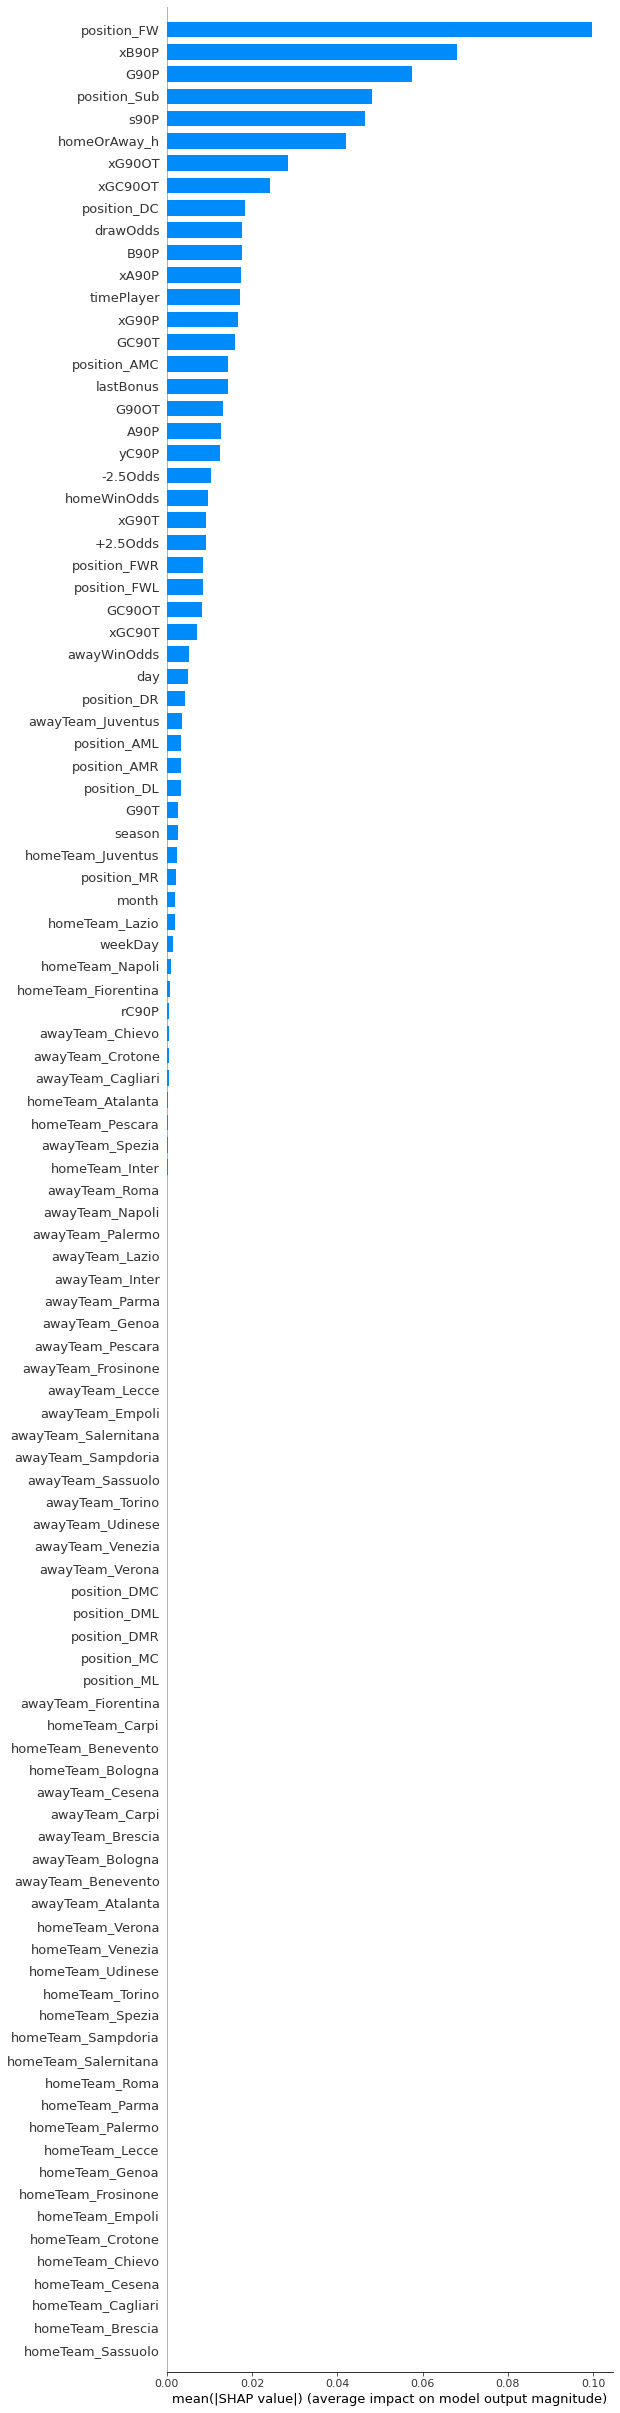

In [106]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, max_display=200, plot_type='bar', show=False, sort=True)